# Dự đoán khoản vay của tổ chức tài chính IBRD nắm giữ các quốc gia

Xác định xem tổ chức nắm giữ khoản vay nhiều hay không, từ đó đánh giá được khả năng tài chính của tổ chức trên

# Tìm hiểu về bộ dữ liệu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.simplefilter('ignore', UserWarning)

pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_csv('IBRD_after_2020.csv')
covid_df = df.copy()

C:\Users\phat0\AppData\Local\Temp\ipykernel_19624\785952262.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('IBRD_after_2020.csv')


In [3]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460062 entries, 0 to 460061
Data columns (total 33 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   End of Period                 460062 non-null  object 
 1   Loan Number                   460062 non-null  object 
 2   Region                        460062 non-null  object 
 3   Country Code                  459958 non-null  object 
 4   Country                       460062 non-null  object 
 5   Borrower                      457098 non-null  object 
 6   Guarantor Country Code        445398 non-null  object 
 7   Guarantor                     445502 non-null  object 
 8   Loan Type                     460062 non-null  object 
 9   Loan Status                   460062 non-null  object 
 10  Interest Rate                 455212 non-null  float64
 11  Currency of Commitment        0 non-null       float64
 12  Project ID                    460062 non-nul

In [4]:
covid_df.head(5)

,End of Period,Loan Number,Region,Country Code,Country,Borrower,Guarantor Country Code,Guarantor,Loan Type,Loan Status,Interest Rate,Currency of Commitment,Project ID,Project Name,Original Principal Amount,Cancelled Amount,Undisbursed Amount,Disbursed Amount,Repaid to IBRD,Due to IBRD,Exchange Adjustment,Borrower's Obligation,Sold 3rd Party,Repaid 3rd Party,Due 3rd Party,Loans Held,First Repayment Date,Last Repayment Date,Agreement Signing Date,Board Approval Date,Effective Date (Most Recent),Closed Date (Most Recent),Last Disbursement Date
0,2022-05-31,IBRD00010,EUROPE AND CENTRAL ASIA,FR,France,CREDIT NATIONAL,FR,France,NPL,Fully Repaid,4.25,NaN,P037383,RECONSTRUCTION,2.500000e+08,0.0,0.0,2.500000e+08,3.800000e+04,0.0,0.00,0.00,2.499620e+08,2.499620e+08,0.0,0.0,11/01/1952 12:00:00 AM,05/01/1977 12:00:00 AM,05/09/1947 12:00:00 AM,05/09/1947 12:00:00 AM,06/09/1947 12:00:00 AM,12/31/1947 12:00:00 AM,NaN
1,2022-05-31,IBRD00020,EUROPE AND CENTRAL ASIA,NL,Netherlands,NaN,NaN,NaN,NPL,Fully Repaid,4.25,NaN,P037452,RECONSTRUCTION,1.910442e+08,0.0,0.0,1.910442e+08,1.033722e+08,0.0,0.00,0.00,8.767200e+07,8.767200e+07,0.0,0.0,04/01/1952 12:00:00 AM,10/01/1972 12:00:00 AM,08/07/1947 12:00:00 AM,08/07/1947 12:00:00 AM,09/11/1947 12:00:00 AM,03/31/1948 12:00:00 AM,NaN
2,2022-05-31,IBRD00021,EUROPE AND CENTRAL ASIA,NL,Netherlands,NaN,NaN,NaN,NPL,Fully Repaid,4.25,NaN,P037452,RECONSTRUCTION,3.955788e+06,0.0,0.0,3.955788e+06,0.000000e+00,0.0,0.00,0.00,3.955788e+06,3.955788e+06,0.0,0.0,04/01/1953 12:00:00 AM,04/01/1954 12:00:00 AM,05/25/1948 12:00:00 AM,08/07/1947 12:00:00 AM,06/01/1948 12:00:00 AM,06/30/1948 12:00:00 AM,NaN
3,2022-05-31,IBRD00030,EUROPE AND CENTRAL ASIA,DK,Denmark,NaN,NaN,NaN,NPL,Fully Repaid,4.25,NaN,P037362,RECONSTRUCTION,4.000000e+07,0.0,0.0,4.000000e+07,1.777100e+07,0.0,0.00,0.00,2.222900e+07,2.222900e+07,0.0,0.0,02/01/1953 12:00:00 AM,08/01/1972 12:00:00 AM,08/22/1947 12:00:00 AM,08/22/1947 12:00:00 AM,10/17/1947 12:00:00 AM,03/31/1949 12:00:00 AM,NaN
4,2022-05-31,IBRD00040,EUROPE AND CENTRAL ASIA,LU,Luxembourg,NaN,NaN,NaN,NPL,Fully Repaid,4.25,NaN,P037451,RECONSTRUCTION,1.200000e+07,0.0,0.0,1.176198e+07,1.619983e+06,0.0,0.01,0.01,1.014200e+07,1.014200e+07,0.0,0.0,07/15/1949 12:00:00 AM,07/15/1972 12:00:00 AM,08/28/1947 12:00:00 AM,08/28/1947 12:00:00 AM,10/24/1947 12:00:00 AM,03/31/1949 12:00:00 AM,NaN


In [5]:
def give_percent_null(dataframe):
    null_vlaue = dataframe.isnull().sum()
    percent_null_value = (null_vlaue / len(dataframe)) * 100
    percent_null_value = percent_null_value[percent_null_value>0]
    if not percent_null_value.empty:
        plt.figure(figsize=(8,6))
        percent_null_value.plot(kind="bar", color='skyblue')
        plt.title('Percent mising value')
        plt.xlabel('columns')
        plt.ylabel('Percent of miss')
        plt.ylim(0,100)
        plt.tight_layout()
        plt.show()
    else:
        print("No columns missing value")

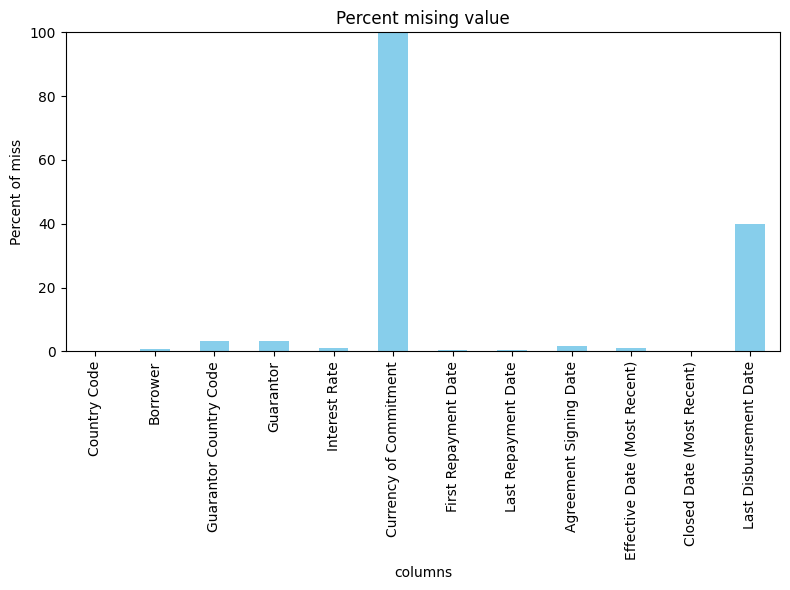

In [6]:
give_percent_null(covid_df)

In [3]:
covid_df = covid_df.drop(columns='Currency of Commitment')

In [8]:
covid_df['Region'].drop_duplicates()

0              EUROPE AND CENTRAL ASIA
5          LATIN AMERICA AND CARIBBEAN
20                          SOUTH ASIA
29        MIDDLE EAST AND NORTH AFRICA
33               EAST ASIA AND PACIFIC
35         EASTERN AND SOUTHERN AFRICA
104         WESTERN AND CENTRAL AFRICA
26755                           AFRICA
26761                      AFRICA EAST
26762                      AFRICA WEST
261647     Eastern and Southern Africa
261714      Western and Central Africa
Name: Region, dtype: object

Ta có thể thấy có các khu vực bị trùng tên như Eastern and Southern Africa và EASTERN AND SOUTHERN AFRICA, Western and Central Africa và WESTERN AND CENTRAL AFRICA

In [4]:
# replacements = {
#     'Eastern and Southern Africa': 'EASTERN AND SOUTHERN AFRICA',
#     'Western and Central Africa': 'WESTERN AND CENTRAL AFRICA'
# }

# Apply replacements
df['Region'] = df['Region'].str.replace('Eastern and Southern Africa', 'EASTERN AND SOUTHERN AFRICA')
df['Region'] = df['Region'].str.replace('Western and Central Africa', 'WESTERN AND CENTRAL AFRICA')
covid_df['Region'] = covid_df['Region'].str.replace('Eastern and Southern Africa', 'EASTERN AND SOUTHERN AFRICA')
covid_df['Region'] = covid_df['Region'].str.replace('Western and Central Africa', 'WESTERN AND CENTRAL AFRICA')

In [10]:
df['Region'].drop_duplicates()

0             EUROPE AND CENTRAL ASIA
5         LATIN AMERICA AND CARIBBEAN
20                         SOUTH ASIA
29       MIDDLE EAST AND NORTH AFRICA
33              EAST ASIA AND PACIFIC
35        EASTERN AND SOUTHERN AFRICA
104        WESTERN AND CENTRAL AFRICA
26755                          AFRICA
26761                     AFRICA EAST
26762                     AFRICA WEST
Name: Region, dtype: object

In [11]:
df_check = df[['Region','Interest Rate','Loans Held']]
df_check

,Region,Interest Rate,Loans Held
0,EUROPE AND CENTRAL ASIA,4.25,0.0
1,EUROPE AND CENTRAL ASIA,4.25,0.0
2,EUROPE AND CENTRAL ASIA,4.25,0.0
3,EUROPE AND CENTRAL ASIA,4.25,0.0
4,EUROPE AND CENTRAL ASIA,4.25,0.0
...,...,...,...
460057,MIDDLE EAST AND NORTH AFRICA,0.00,0.0
460058,MIDDLE EAST AND NORTH AFRICA,7.95,0.0
460059,MIDDLE EAST AND NORTH AFRICA,8.25,0.0
460060,LATIN AMERICA AND CARIBBEAN,8.25,0.0


In [12]:
df_groupby = df_check.groupby(['Region','Interest Rate'], as_index=False).mean()
df_groupby

,Region,Interest Rate,Loans Held
0,AFRICA,0.00,1.094569e+08
1,AFRICA,0.31,0.000000e+00
2,AFRICA,0.49,0.000000e+00
3,AFRICA,0.51,-8.333333e-04
4,AFRICA,0.56,-1.666667e-03
...,...,...,...
1942,WESTERN AND CENTRAL AFRICA,8.90,-1.000000e+06
1943,WESTERN AND CENTRAL AFRICA,9.25,0.000000e+00
1944,WESTERN AND CENTRAL AFRICA,9.60,0.000000e+00
1945,WESTERN AND CENTRAL AFRICA,10.60,0.000000e+00


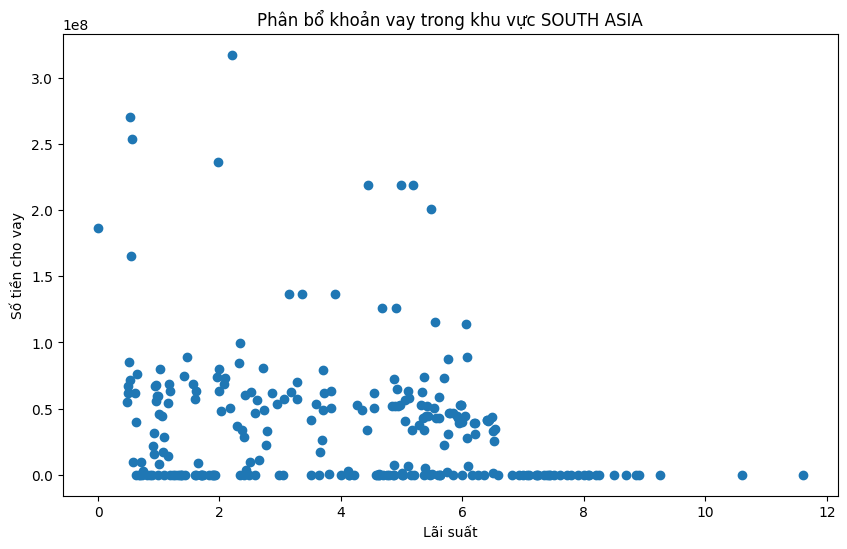

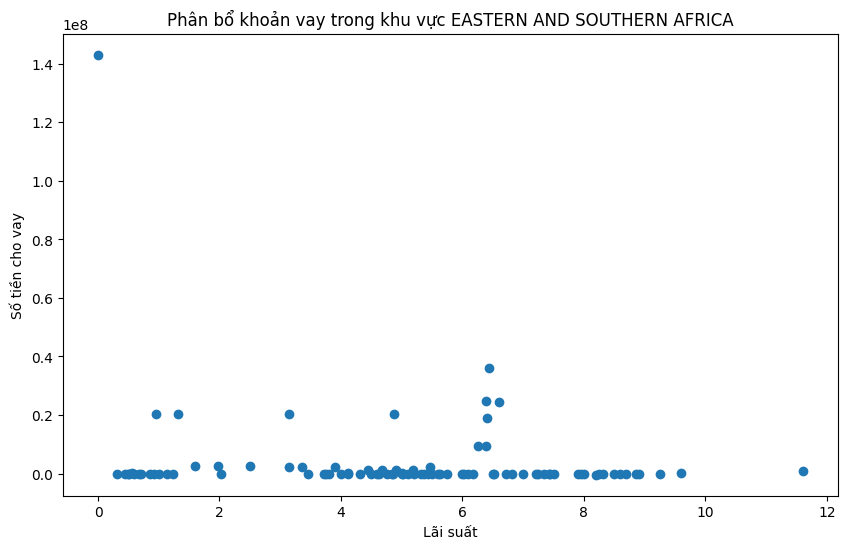

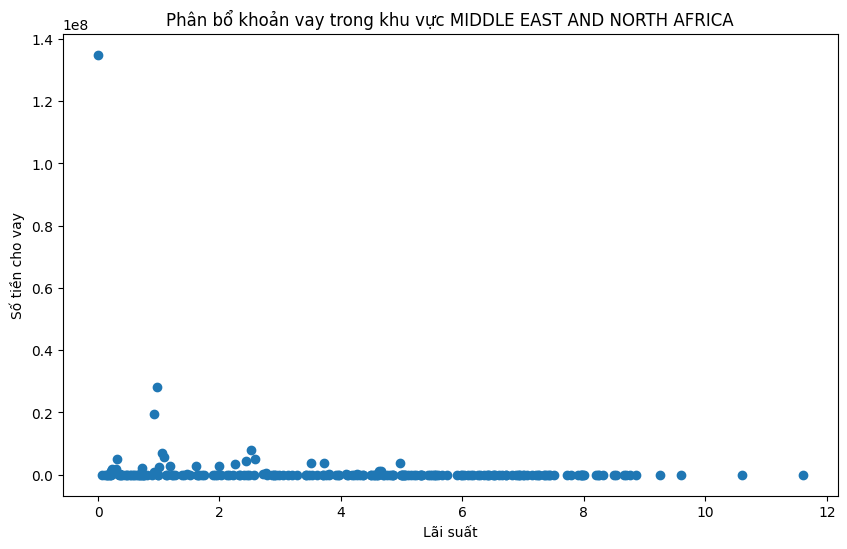

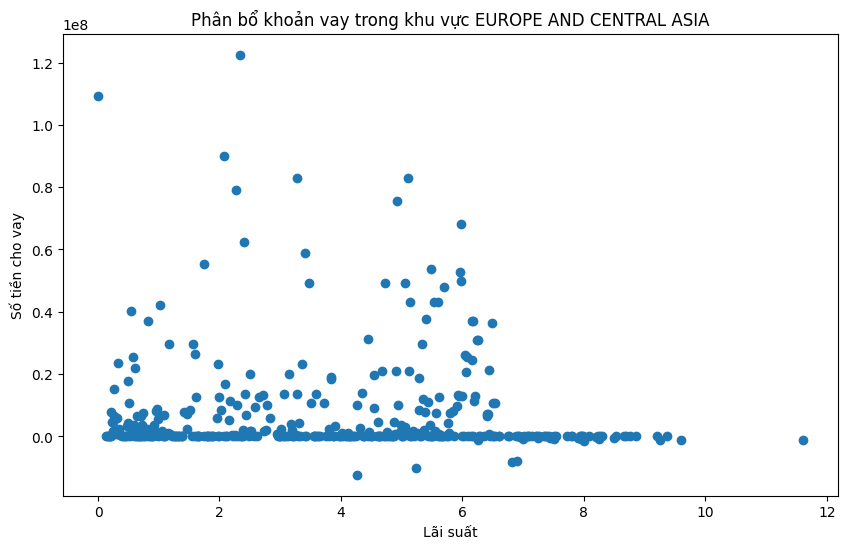

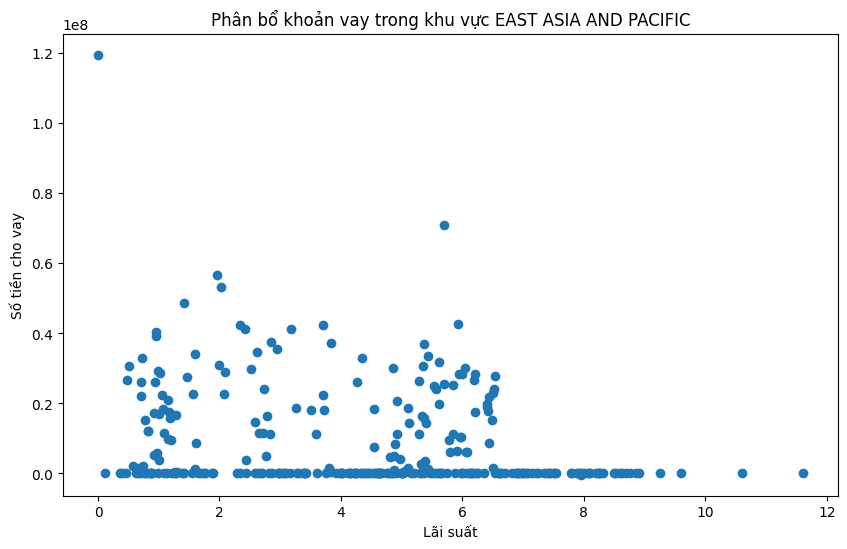

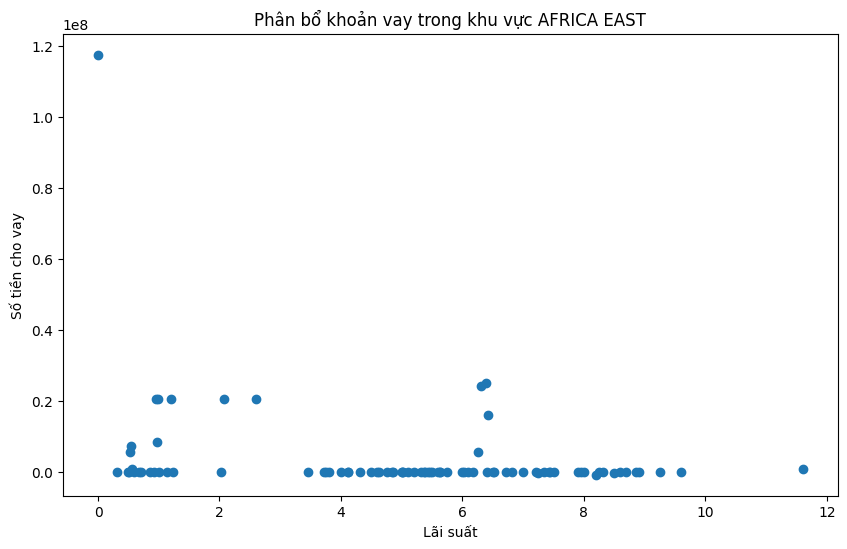

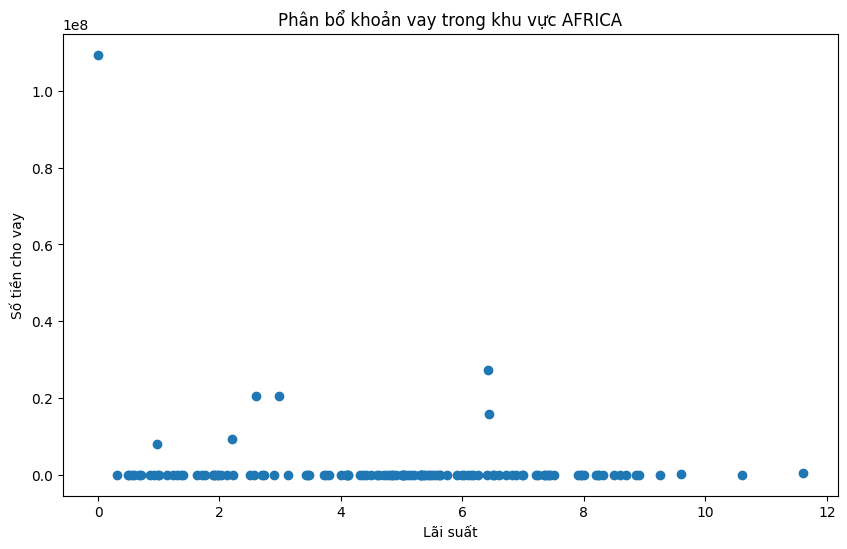

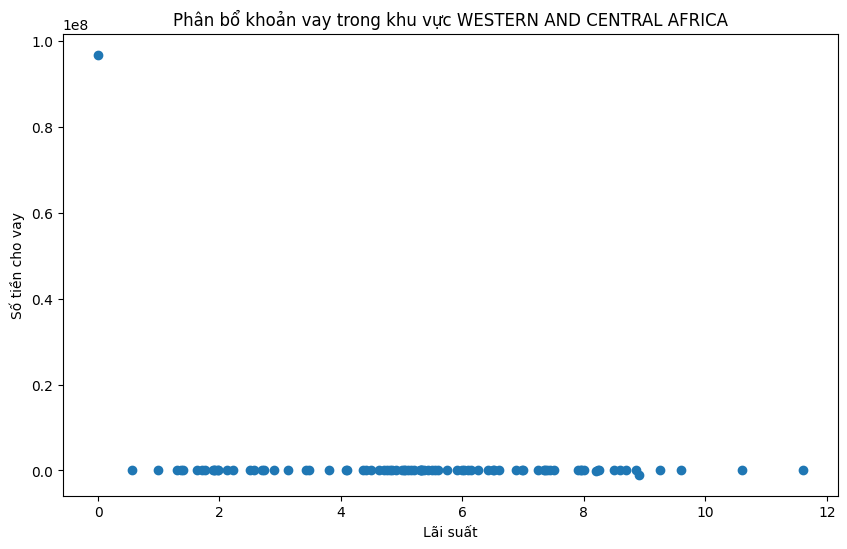

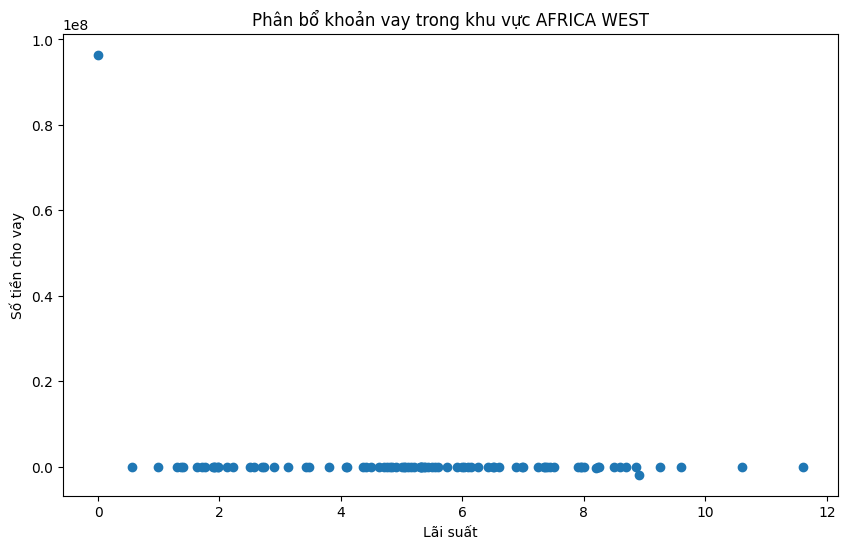

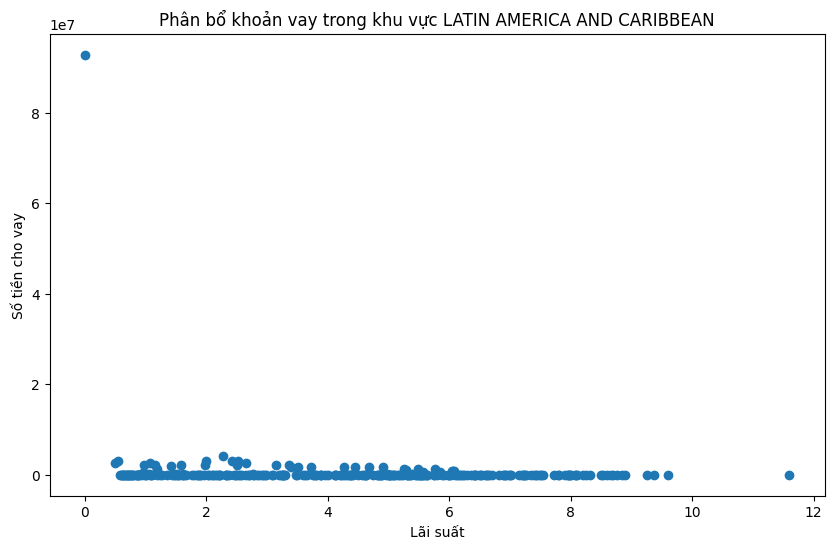

In [13]:
# Sắp xếp dữ liệu theo 'Loans Held' giảm dần
df_sorted = df_groupby.sort_values('Loans Held', ascending=False)

# Lặp qua từng 'Region'
for region in df_sorted['Region'].unique():
    # Lấy dữ liệu cho 'Region' hiện tại
    df_region = df_sorted[df_sorted['Region'] == region]

    # Tạo thanh biểu đồ
    plt.figure(figsize=(10, 6))
    plt.scatter(df_region['Interest Rate'], df_region['Loans Held'])
    plt.xlabel('Lãi suất')
    plt.ylabel('Số tiền cho vay')
    plt.title(f'Phân bổ khoản vay trong khu vực {region}')
    plt.show()


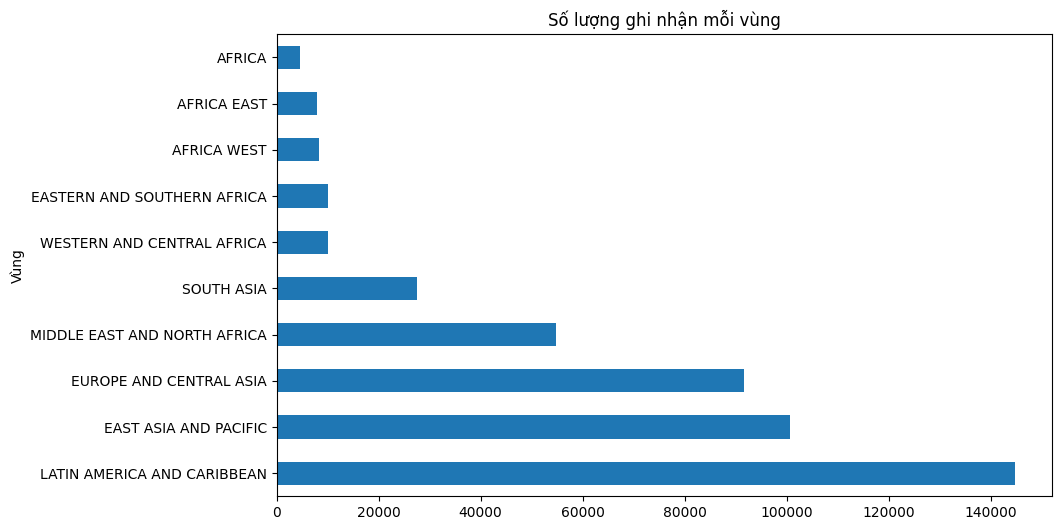

In [14]:
region_counts = df['Region'].value_counts()

plt.figure(figsize=(10, 6))
region_counts.plot(kind='barh')
plt.title('Số lượng ghi nhận mỗi vùng')
plt.ylabel('Vùng')
plt.show()

In [59]:
# Chuyển đổi các cột ngày tháng về kiểu datetime
df['First Repayment Date'] = pd.to_datetime(df['First Repayment Date'])
df['Last Repayment Date'] = pd.to_datetime(df['Last Repayment Date'])

# Tính thời gian vay
df['Loan Duration'] = (df['Last Repayment Date'] - df['First Repayment Date']).dt.days

# Nhóm dữ liệu theo quốc gia và tính toán thời gian vay trung bình
country_loan_duration = df.groupby('Country')['Loan Duration'].mean().astype(int)

# Tìm đất nước có thời gian vay trung bình dài nhất
max_duration_country = country_loan_duration.idxmax()
max_duration = country_loan_duration.max()

print(f'Country with the longest average loan duration: {max_duration_country} ({max_duration} days)')

Country with the longest average loan duration: Kosovo (9680 days)


In [16]:
# Nhóm dữ liệu theo vùng và tính toán thời gian vay trung bình
region_loan_duration = df.groupby('Region')['Loan Duration'].mean().astype(int)

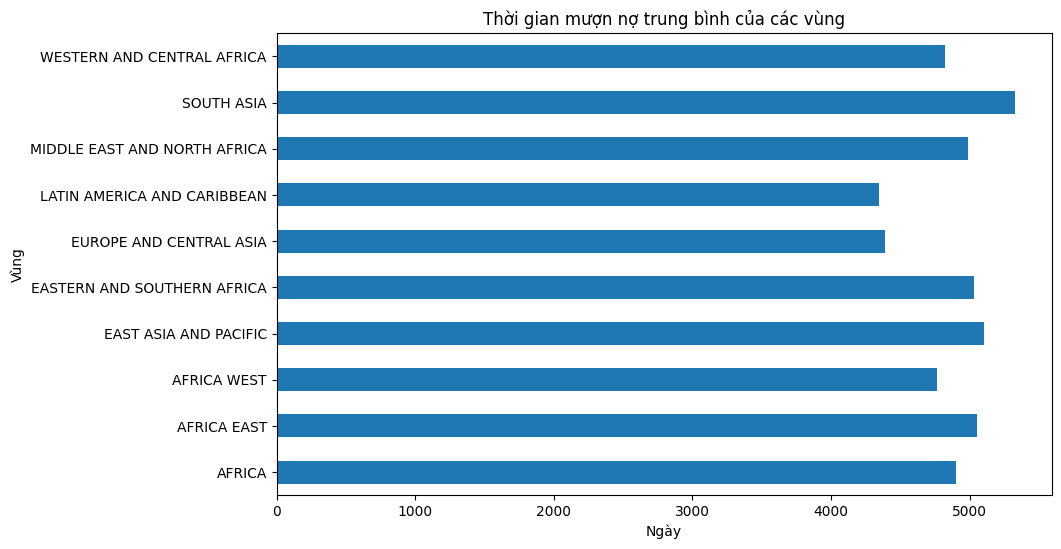

In [17]:
plt.figure(figsize=(10, 6))
region_loan_duration.plot(kind='barh')
plt.title('Thời gian mượn nợ trung bình của các vùng')
plt.xlabel('Ngày')
plt.ylabel('Vùng')
plt.show()

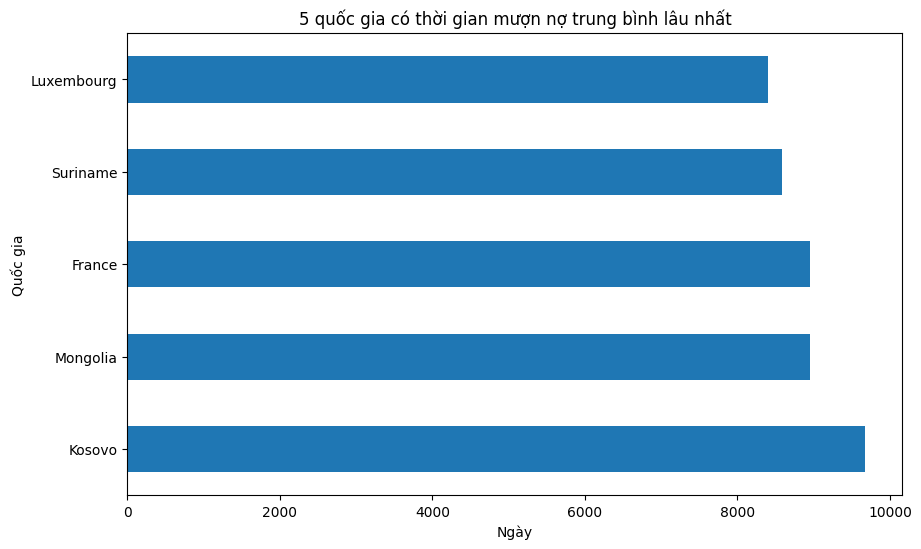

In [18]:
country_loan_duration = country_loan_duration.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
country_loan_duration.head(5).plot(kind='barh')
plt.title('5 quốc gia có thời gian mượn nợ trung bình lâu nhất')
plt.xlabel('Ngày')
plt.ylabel('Quốc gia')
plt.show()

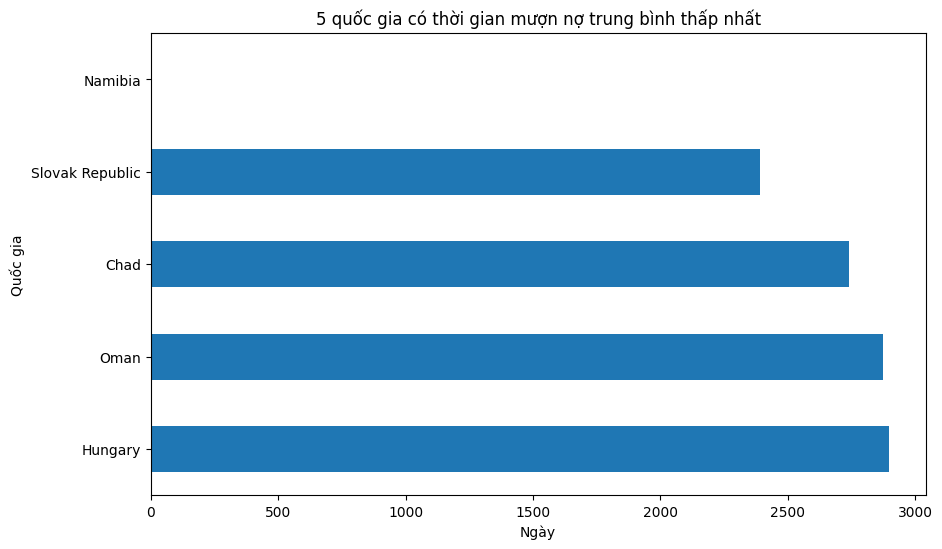

In [19]:
plt.figure(figsize=(10, 6))
country_loan_duration.tail(5).plot(kind='barh')
plt.title('5 quốc gia có thời gian mượn nợ trung bình thấp nhất')
plt.xlabel('Ngày')
plt.ylabel('Quốc gia')
plt.show()

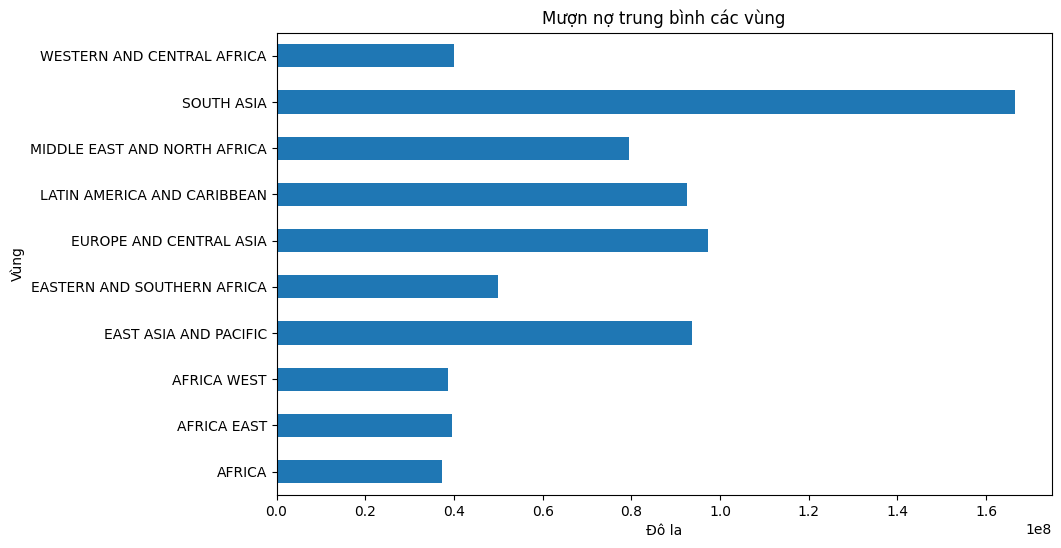

In [20]:
# Nhóm dữ liệu theo vùng và tính toán số lượng tiền vay ban đầu theo hợp đồng trung bình
region_principal_amount = df.groupby('Region')['Original Principal Amount'].mean()

plt.figure(figsize=(10, 6))
region_principal_amount.plot(kind='barh')
plt.title('Mượn nợ trung bình các vùng')
plt.xlabel('Đô la')
plt.ylabel('Vùng')
plt.show()

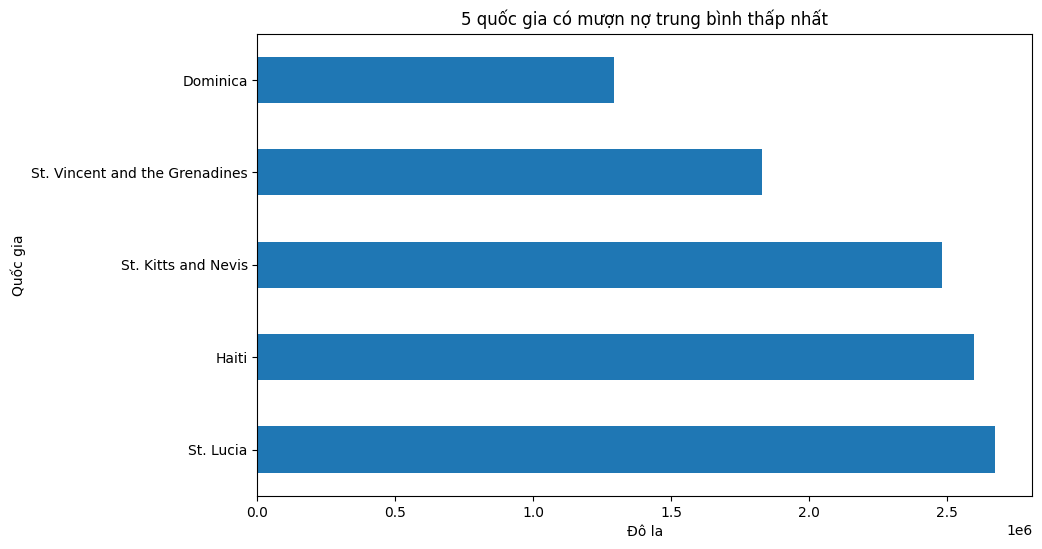

In [21]:
# Nhóm dữ liệu theo quốc gia và tính toán số lượng tiền vay ban đầu theo hợp đồng trung bình
country_principal_amount = df.groupby('Country')['Original Principal Amount'].mean()
country_principal_amount = country_principal_amount.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
country_principal_amount.tail(5).plot(kind='barh')
plt.title('5 quốc gia có mượn nợ trung bình thấp nhất')
plt.xlabel('Đô la')
plt.ylabel('Quốc gia')
plt.show()

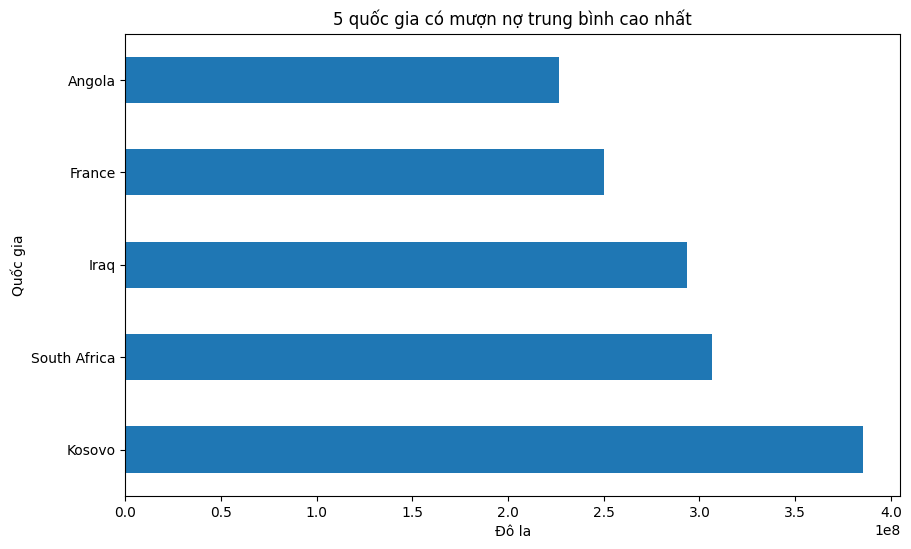

In [22]:
plt.figure(figsize=(10, 6))
country_principal_amount.head(5).plot(kind='barh')
plt.title('5 quốc gia có mượn nợ trung bình cao nhất')
plt.xlabel('Đô la')
plt.ylabel('Quốc gia')
plt.show()

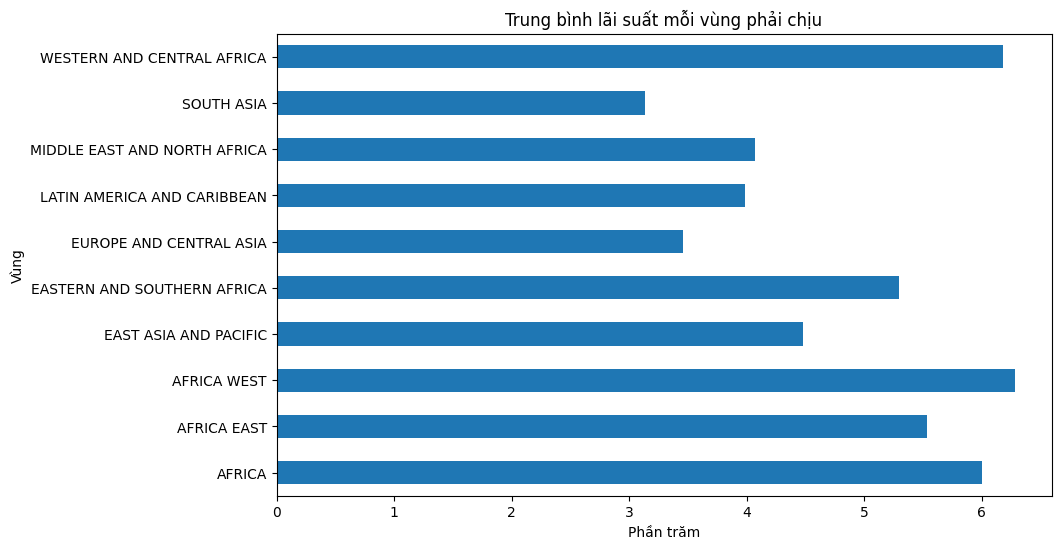

In [23]:
# Lãi suất trung bình mỗi vùng
IR_region = df.groupby('Region')['Interest Rate'].mean()
plt.figure(figsize=(10, 6))
IR_region.plot(kind='barh')
plt.title('Trung bình lãi suất mỗi vùng phải chịu')
plt.xlabel('Phần trăm')
plt.ylabel('Vùng')
plt.show()

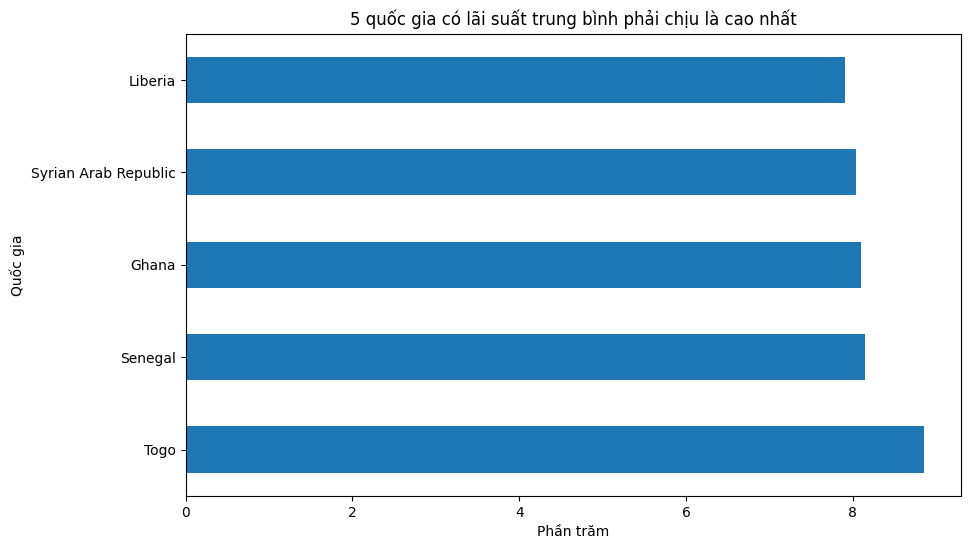

In [24]:
# Lãi suất trung bình mỗi quốc gia
IR_country = df.groupby('Country')['Interest Rate'].mean()
IR_country = IR_country.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
IR_country.head(5).plot(kind='barh')
plt.title('5 quốc gia có lãi suất trung bình phải chịu là cao nhất')
plt.xlabel('Phần trăm')
plt.ylabel('Quốc gia')
plt.show()

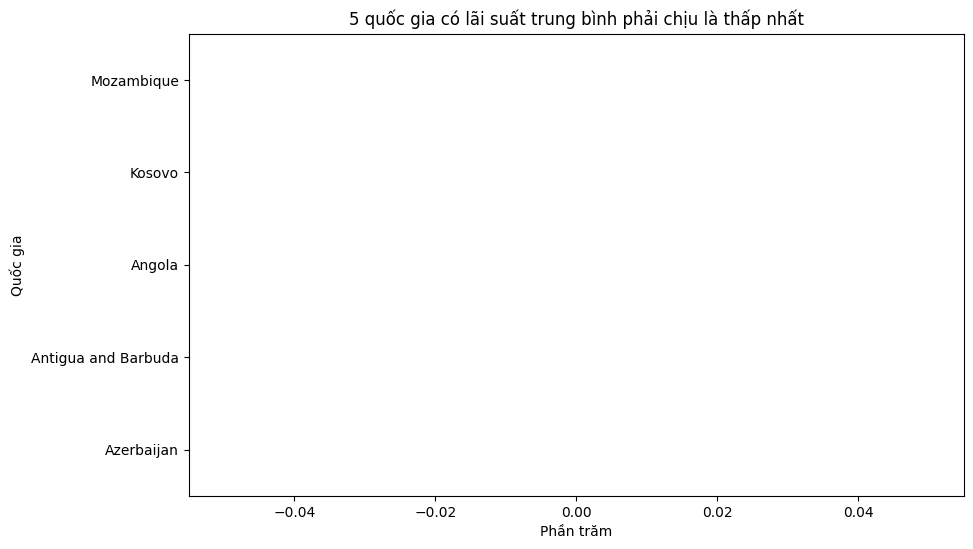

In [25]:
plt.figure(figsize=(10, 6))
IR_country.tail(5).plot(kind='barh')
plt.title('5 quốc gia có lãi suất trung bình phải chịu là thấp nhất')
plt.xlabel('Phần trăm')
plt.ylabel('Quốc gia')
plt.show()

Không có thống kê

# Encoder các cột

In [26]:
# Kiểm tra số lượng quốc gia (Country và Country Code)
print(covid_df['Country'].drop_duplicates().count())
print(covid_df['Country Code'].drop_duplicates().count())

152
146


Sử dụng Country sẽ đầy đủ hơn

In [27]:
# Đếm số quốc gia bảo lãnh (Guarantor và Guarantor Country Code)
print(covid_df['Guarantor'].drop_duplicates().count())
print(covid_df['Guarantor Country Code'].drop_duplicates().count())

130
125


Sử dụng Guarantor sẽ đầy đủ hơn

In [5]:
covid_df = covid_df.rename(columns={'Project Name ': 'Project Name'})

In [6]:
covid_df.dropna(inplace=True)

In [30]:
covid_df.describe()

,Interest Rate,Original Principal Amount,Cancelled Amount,Undisbursed Amount,Disbursed Amount,Repaid to IBRD,Due to IBRD,Exchange Adjustment,Borrower's Obligation,Sold 3rd Party,Repaid 3rd Party,Due 3rd Party,Loans Held
count,275670.000000,2.756700e+05,2.756700e+05,2.756700e+05,2.756700e+05,2.756700e+05,2.756700e+05,2.756700e+05,2.756700e+05,2.756700e+05,2.756700e+05,2.756700e+05,2.756700e+05
mean,2.619214,1.242635e+08,1.386355e+07,9.365348e+06,1.006194e+08,5.665640e+07,4.407947e+07,-1.203128e+06,4.287634e+07,8.313709e+03,8.313709e+03,3.377226e-15,5.344482e+07
std,3.142400,1.931436e+08,5.137606e+07,4.327318e+07,1.781401e+08,1.145903e+08,1.361931e+08,1.734783e+07,1.299193e+08,2.094021e+05,2.094021e+05,1.773189e-12,1.459831e+08
min,0.000000,0.000000e+00,0.000000e+00,-1.000000e-02,-7.920000e-09,0.000000e+00,-1.483090e+08,-1.100785e+09,-2.300000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-1.483090e+08
25%,0.000000,2.356000e+07,0.000000e+00,0.000000e+00,1.367255e+07,3.876743e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.760000,6.000000e+07,3.825772e+05,0.000000e+00,4.000000e+07,2.089104e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.520000,1.500000e+08,8.006103e+06,0.000000e+00,1.098767e+08,6.484665e+07,1.764559e+07,0.000000e+00,1.635688e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.062944e+07
max,11.600000,3.750000e+09,1.995000e+09,1.439821e+09,3.153531e+09,3.000000e+09,2.728704e+09,1.483090e+08,2.149000e+09,8.177902e+06,8.177902e+06,9.310000e-10,3.395722e+09


In [7]:
# Encode các cột Country, Region, Guarantor
enc = OrdinalEncoder()
covid_df[['Country', 'Region', 'Guarantor', 'Loan Status', 'Loan Type', 'Project Name', 'Borrower']] = \
    enc.fit_transform(covid_df[['Country', 'Region', 'Guarantor', 'Loan Status', 'Loan Type', 'Project Name', 'Borrower']])

In [8]:
covid_df['First Repayment Date'] = pd.to_datetime(covid_df['First Repayment Date'])
covid_df['Last Repayment Date'] = pd.to_datetime(covid_df['Last Repayment Date'])

In [9]:
covid_df['Loan Duration'] = (covid_df['Last Repayment Date'] - covid_df['First Repayment Date']).dt.days

In [34]:
corr = covid_df.select_dtypes(np.number).drop(columns=['Cancelled Amount', 'Undisbursed Amount',
                                                       'Disbursed Amount', 'Repaid to IBRD', 'Due to IBRD',
                                                       'Sold 3rd Party', 'Repaid 3rd Party', 'Due 3rd Party']).corr()
corr.style.background_gradient(cmap='coolwarm')

,Region,Country,Borrower,Guarantor,Loan Type,Loan Status,Interest Rate,Project Name,Original Principal Amount,Exchange Adjustment,Borrower's Obligation,Loans Held,Loan Duration
Region,1.000000,-0.001420,-0.129419,-0.000651,-0.033566,-0.045525,-0.030221,0.012765,0.039231,0.011573,0.019283,0.032505,-0.026033
Country,-0.001420,1.000000,-0.018855,0.999165,-0.001738,0.009342,0.060383,0.345513,0.000608,-0.062827,0.002638,0.009740,-0.081841
Borrower,-0.129419,-0.018855,1.000000,-0.017970,0.032474,0.029773,-0.086153,-0.058876,0.006785,0.000406,0.054582,0.034883,-0.024677
Guarantor,-0.000651,0.999165,-0.017970,1.000000,-0.001027,0.009282,0.060035,0.346563,0.000547,-0.062951,0.002606,0.009725,-0.082350
Loan Type,-0.033566,-0.001738,0.032474,-0.001027,1.000000,0.076720,-0.354209,-0.064148,0.009860,0.010562,-0.051606,-0.059374,-0.072507
Loan Status,-0.045525,0.009342,0.029773,0.009282,0.076720,1.000000,0.236949,-0.068290,-0.110094,-0.023089,-0.151258,-0.298868,-0.087895
Interest Rate,-0.030221,0.060383,-0.086153,0.060035,-0.354209,0.236949,1.000000,0.100695,-0.208815,0.063967,-0.268649,-0.300161,-0.095096
Project Name,0.012765,0.345513,-0.058876,0.346563,-0.064148,-0.068290,0.100695,1.000000,-0.051832,-0.014337,-0.030979,-0.019413,-0.054089
Original Principal Amount,0.039231,0.000608,0.006785,0.000547,0.009860,-0.110094,-0.208815,-0.051832,1.000000,-0.350468,0.719016,0.744814,0.070257
Exchange Adjustment,0.011573,-0.062827,0.000406,-0.062951,0.010562,-0.023089,0.063967,-0.014337,-0.350468,1.000000,-0.303621,-0.394479,-0.029579


In [35]:
corr1 = covid_df.select_dtypes(np.number).corr()
corr1.style.background_gradient(cmap='coolwarm')

,Region,Country,Borrower,Guarantor,Loan Type,Loan Status,Interest Rate,Project Name,Original Principal Amount,Cancelled Amount,Undisbursed Amount,Disbursed Amount,Repaid to IBRD,Due to IBRD,Exchange Adjustment,Borrower's Obligation,Sold 3rd Party,Repaid 3rd Party,Due 3rd Party,Loans Held,Loan Duration
Region,1.000000,-0.001420,-0.129419,-0.000651,-0.033566,-0.045525,-0.030221,0.012765,0.039231,0.028634,0.056403,0.020995,0.012749,0.016921,0.011573,0.019283,-0.022733,-0.022733,0.001935,0.032505,-0.026033
Country,-0.001420,1.000000,-0.018855,0.999165,-0.001738,0.009342,0.060383,0.345513,0.000608,0.015315,-0.000250,-0.004897,-0.020226,0.010520,-0.062827,0.002638,0.047399,0.047399,0.002943,0.009740,-0.081841
Borrower,-0.129419,-0.018855,1.000000,-0.017970,0.032474,0.029773,-0.086153,-0.058876,0.006785,-0.054552,-0.046030,0.034006,-0.009083,0.052016,0.000406,0.054582,-0.009231,-0.009231,0.000430,0.034883,-0.024677
Guarantor,-0.000651,0.999165,-0.017970,1.000000,-0.001027,0.009282,0.060035,0.346563,0.000547,0.015323,-0.000255,-0.004966,-0.020316,0.010505,-0.062951,0.002606,0.047649,0.047649,0.002948,0.009725,-0.082350
Loan Type,-0.033566,-0.001738,0.032474,-0.001027,1.000000,0.076720,-0.354209,-0.064148,0.009860,0.015876,-0.041129,0.013976,0.083377,-0.050574,0.010562,-0.051606,0.025163,0.025163,0.001207,-0.059374,-0.072507
Loan Status,-0.045525,0.009342,0.029773,0.009282,0.076720,1.000000,0.236949,-0.068290,-0.110094,0.052716,-0.563373,0.004053,0.174343,-0.141349,-0.023089,-0.151258,0.010649,0.010649,0.000511,-0.298868,-0.087895
Interest Rate,-0.030221,0.060383,-0.086153,0.060035,-0.354209,0.236949,1.000000,0.100695,-0.208815,0.001622,-0.180390,-0.182110,0.030623,-0.264421,0.063967,-0.268649,0.067860,0.067860,0.002958,-0.300161,-0.095096
Project Name,0.012765,0.345513,-0.058876,0.346563,-0.064148,-0.068290,0.100695,1.000000,-0.051832,0.007406,0.021771,-0.064179,-0.066749,-0.027726,-0.014337,-0.030979,-0.011889,-0.011889,-0.000718,-0.019413,-0.054089
Original Principal Amount,0.039231,0.000608,0.006785,0.000547,0.009860,-0.110094,-0.208815,-0.051832,1.000000,0.314103,0.213444,0.937417,0.588782,0.730535,-0.350468,0.719016,-0.014734,-0.014734,-0.000910,0.744814,0.070257
Cancelled Amount,0.028634,0.015315,-0.054552,0.015323,0.015876,0.052716,0.001622,0.007406,0.314103,1.000000,-0.033458,0.060318,0.066918,0.022420,-0.055086,0.016147,-0.007297,-0.007297,-0.000434,0.010999,0.003571


Sử dụng Interest Rate, Original Principal Amount (số tiền vay ban đầu), Exchange Adjustment, Loan Status và Loan Duration

Có thể xem xét các cột còn lại trong corr trừ Borrower's Obligation

Borrower's Obligation có độ tương quan với giá trị của tương lai là Due to IBRD khá cao nên sẽ không dùng

# Importance Feature

In [36]:
X = covid_df.drop(columns='Loans Held').select_dtypes(np.number)
y = covid_df['Loans Held']

model = LinearRegression()
model.fit(X, y)

importance = model.coef_
for i,v in enumerate(importance):
    print(covid_df.columns[i], ', Score: %.5f' % (v))

# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

End of Period , Score: -0.00000
Loan Number , Score: -0.00000
Region , Score: 0.00000
Country Code , Score: 0.00000
Country , Score: -0.00000
Borrower , Score: -0.00000
Guarantor Country Code , Score: -0.00000
Guarantor , Score: 0.00000
Loan Type , Score: 0.00000
Loan Status , Score: -0.00000
Interest Rate , Score: 1.00000
Project ID , Score: -0.00000
Project Name , Score: -0.00000
Original Principal Amount , Score: 0.76343
Cancelled Amount , Score: -0.23657
Undisbursed Amount , Score: 0.23657
Disbursed Amount , Score: 0.00000
Repaid to IBRD , Score: -0.00000
Due to IBRD , Score: 0.00000
Exchange Adjustment , Score: 0.00000


Tính feature importance dựa trên null importance

In [37]:
categorical_feats = [
    f for f in covid_df.columns if covid_df[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    covid_df[f_], _ = pd.factorize(covid_df[f_])
    covid_df[f_] = covid_df[f_].astype('category')

In [38]:
def get_null_importance(data, shuffle, n_iterations=10, seed=None):
    # Gather real features
    train_features = [f for f in data if f != 'Loans Held' and f != 'First Repayment Date' and f != 'Last Repayment Date']
    
    # Shuffle target if required
    y = data['Loans Held'].copy()
    if shuffle:
        y = data['Loans Held'].copy().sample(frac=1.0)
    
    # Initialize arrays to store null importances
    null_importances_gain = np.zeros((n_iterations, len(train_features)))
    null_importances_split = np.zeros((n_iterations, len(train_features)))
    
    # Fit LightGBM model for each iteration
    for i in range(n_iterations):
        # Shuffle the target
        y_shuffled = y.sample(frac=1.0, random_state=seed if seed is None else seed+i)
        
        # Fit LightGBM model
        dtrain = lgb.Dataset(data[train_features], y_shuffled, free_raw_data=False)
        lgb_params = {
            'objective': 'binary',
            'boosting_type': 'rf',
            'subsample': 0.623,
            'colsample_bytree': 0.7,
            'num_leaves': 127,
            'max_depth': 8,
            'seed': seed,
            'bagging_freq': 1,
            'n_jobs': 4
        }
        clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)
        
        # Get feature importances for this iteration
        null_importances_gain[i, :] = clf.feature_importance(importance_type='gain')
        null_importances_split[i, :] = clf.feature_importance(importance_type='split')
    
    # Compute average feature importances
    average_importances_gain = null_importances_gain.mean(axis=0)
    average_importances_split = null_importances_split.mean(axis=0)
    
    # Create DataFrame to store importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = train_features
    imp_df["importance_gain"] = average_importances_gain
    imp_df["importance_split"] = average_importances_split
    imp_df['trn_score'] = mean_squared_error(y, clf.predict(data[train_features]))
    
    return imp_df

In [39]:
actual_imp_df = get_null_importance(data=covid_df, shuffle=False)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 100975, number of negative: 174695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27489
[LightGBM] [Info] Number of data points in the train set: 275670, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366289 -> initscore=-0.548169
[LightGBM] [Info] Start training from score -0.548169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [40]:
null_imp_df = pd.DataFrame()
nb_runs = 5
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_null_importance(data=covid_df, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 100975, number of negative: 174695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27489
[LightGBM] [Info] Number of data points in the train set: 275670, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366289 -> initscore=-0.548169
[LightGBM] [Info] Start training from score -0.548169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [41]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

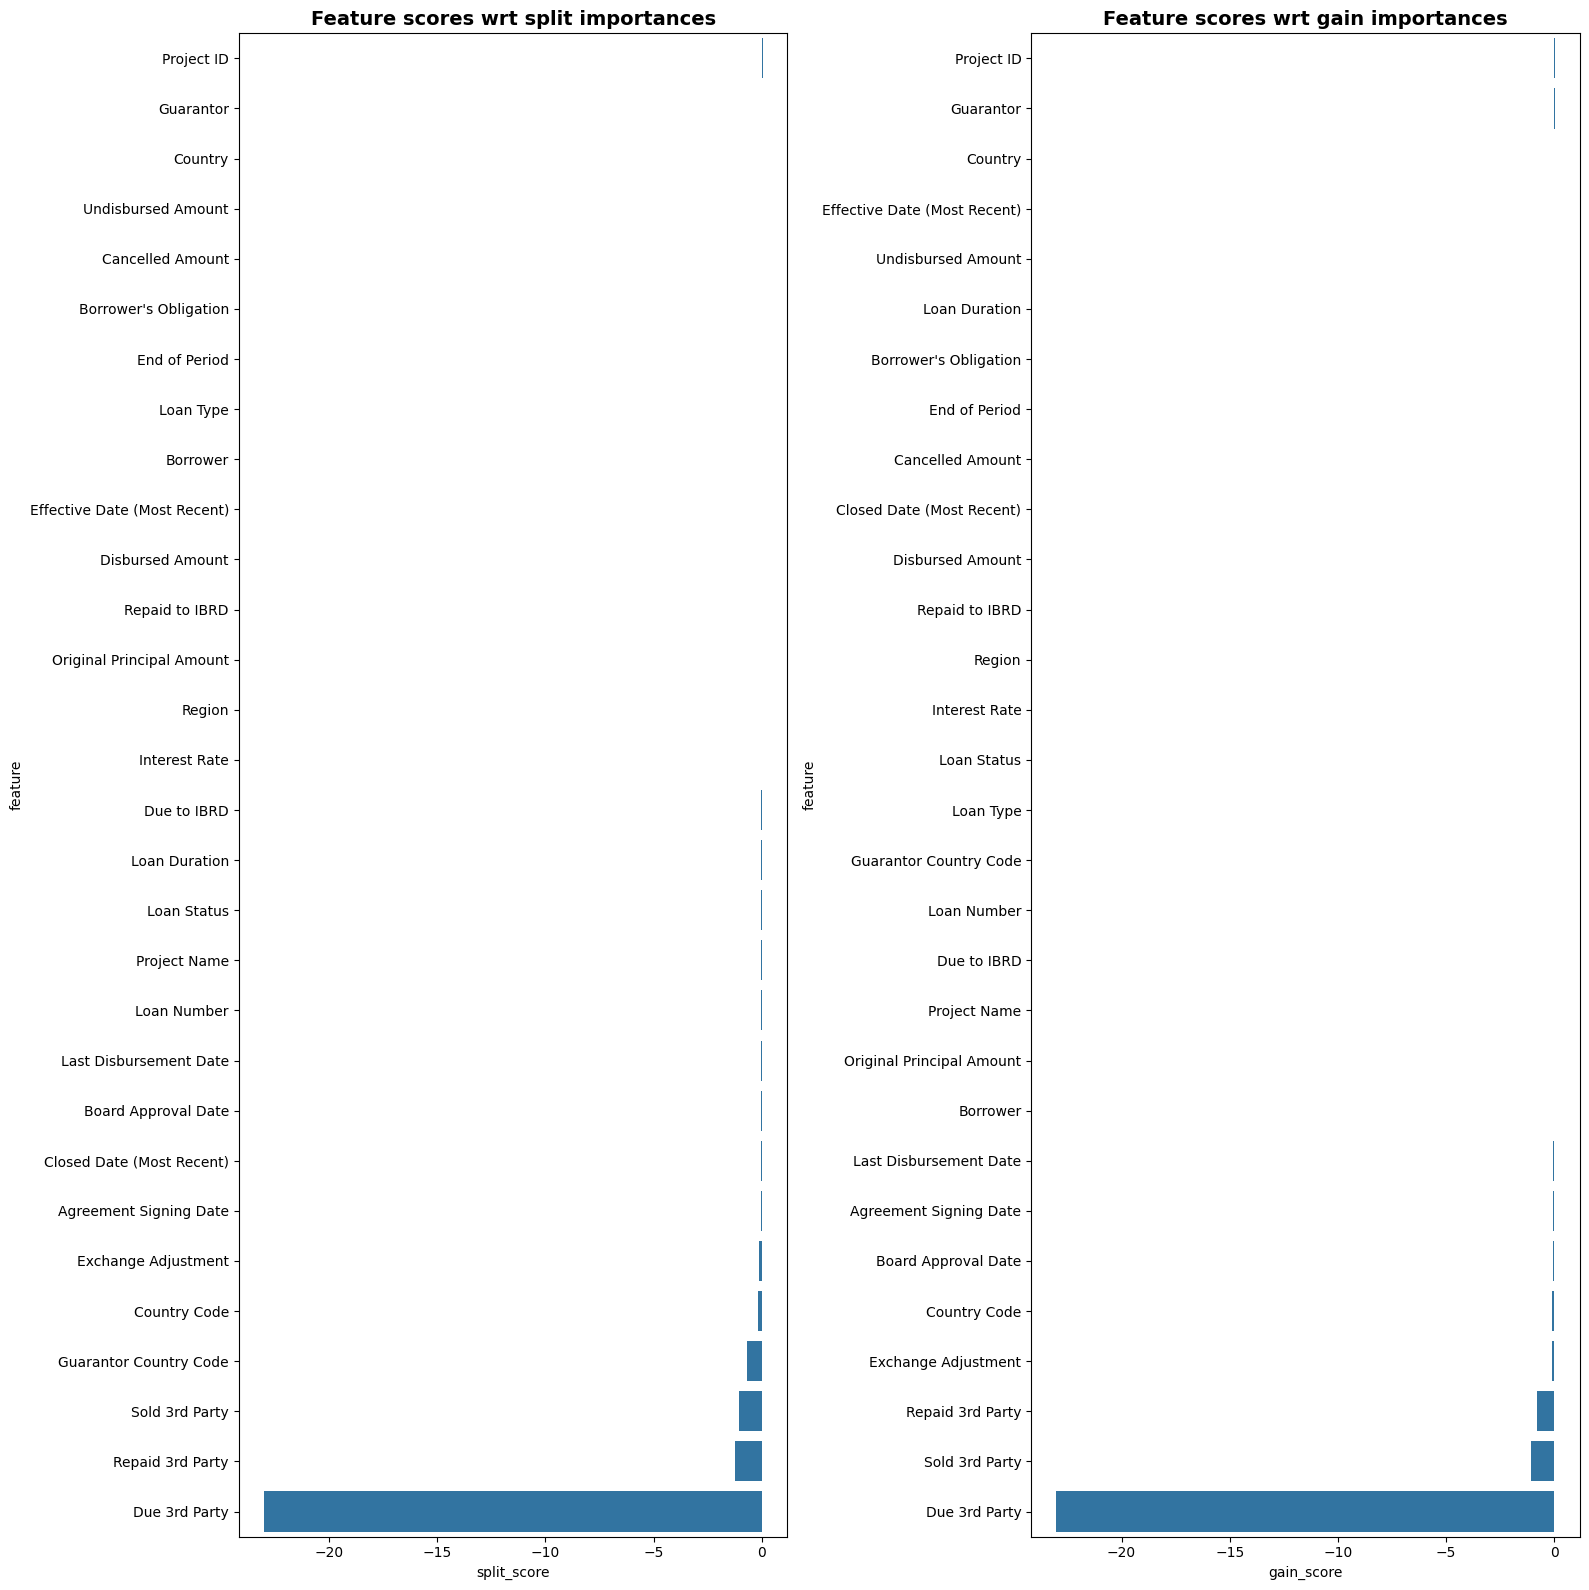

In [42]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

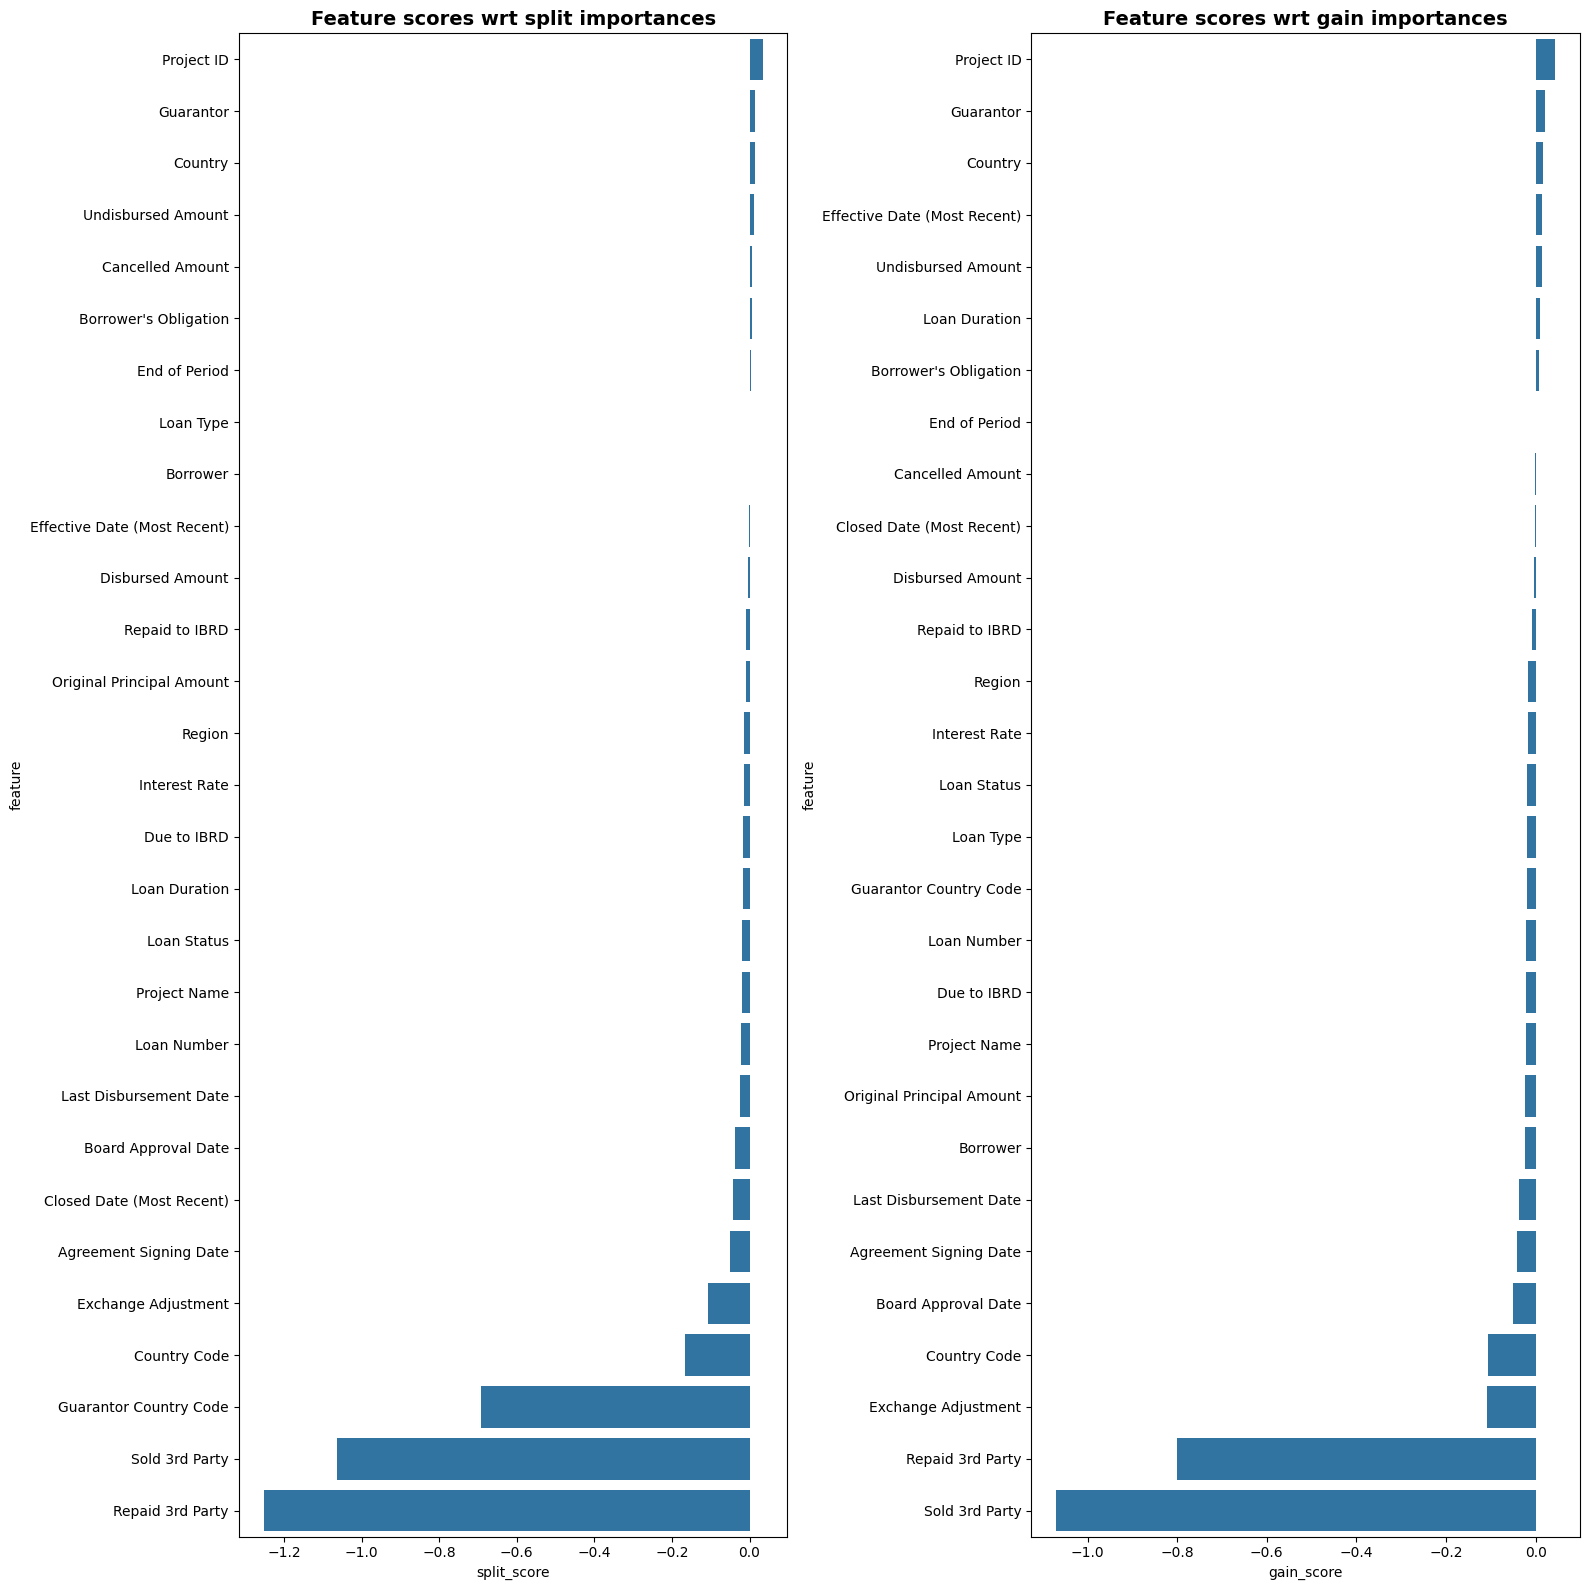

In [43]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    if _f != 'Due 3rd Party':   
        f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
        f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
        gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
        f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
        f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
        split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
        feature_scores.append((_f, split_score, gain_score))
        feature_scores = [_f for _f in feature_scores if _f[0] != 'Due_3rd_Party']
scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

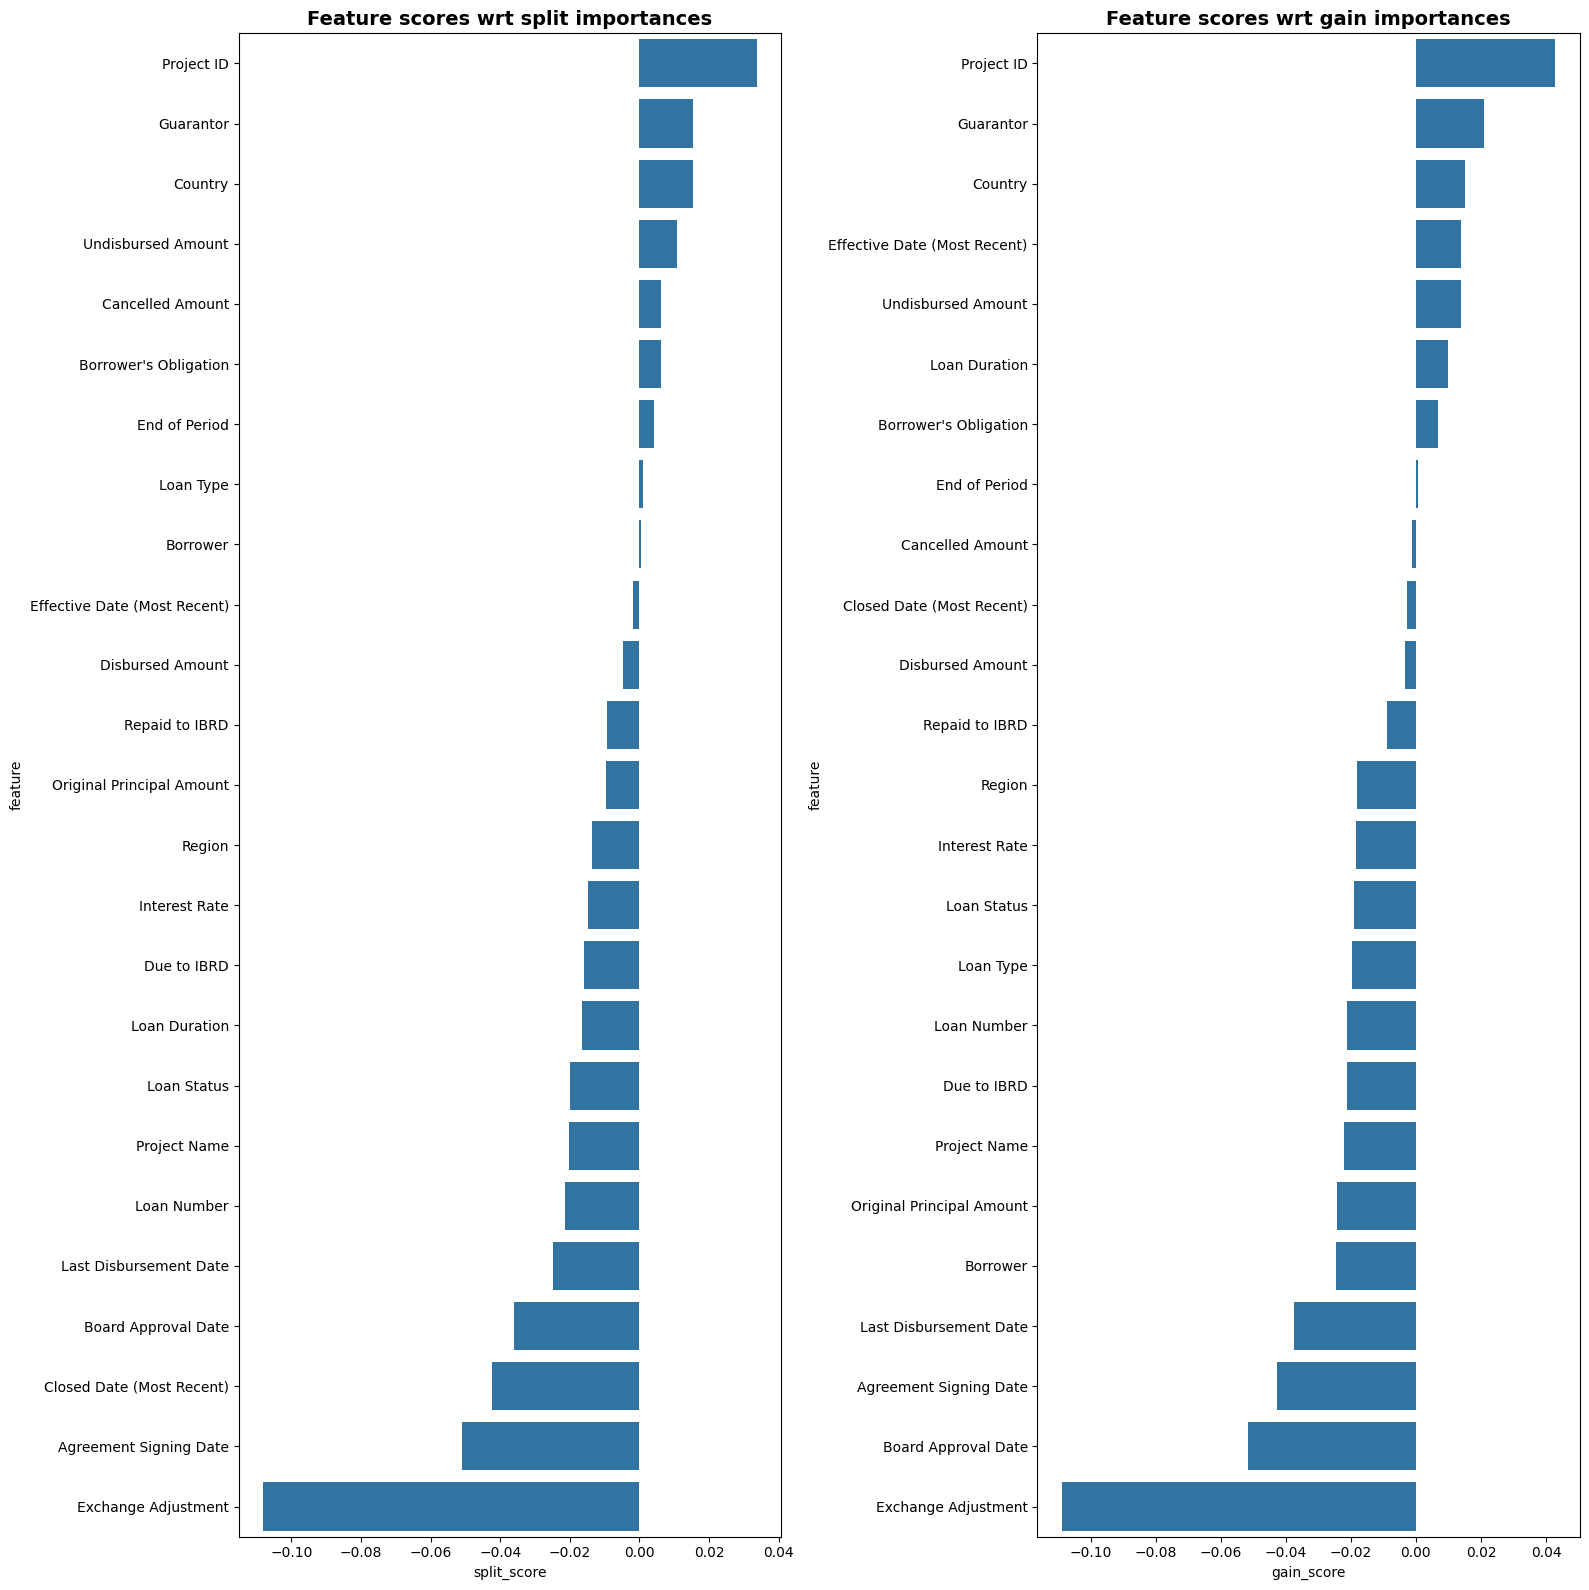

In [44]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    if _f != 'Due 3rd Party' and _f != 'Guarantor Country Code' and _f != 'Repaid 3rd Party' and _f != 'Country Code' and _f != 'Sold 3rd Party':
        f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
        f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
        gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
        f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
        f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
        split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
        feature_scores.append((_f, split_score, gain_score))
        feature_scores = [_f for _f in feature_scores if _f[0] != 'Due_3rd_Party']
scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

Cân nhắc xài Region, Country, Guarantor và Borrower

# PCA

PCA

Code nguồn tham khảo: https://www.geeksforgeeks.org/principal-component-analysis-pca/

In [10]:
X = covid_df[['Interest Rate', 'Original Principal Amount', 'Exchange Adjustment', 'Loan Status', 'Loan Duration', 'Country', 'Borrower', 'Guarantor']]

# Mean
X_mean = X.mean()

# Standard deviation
X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std


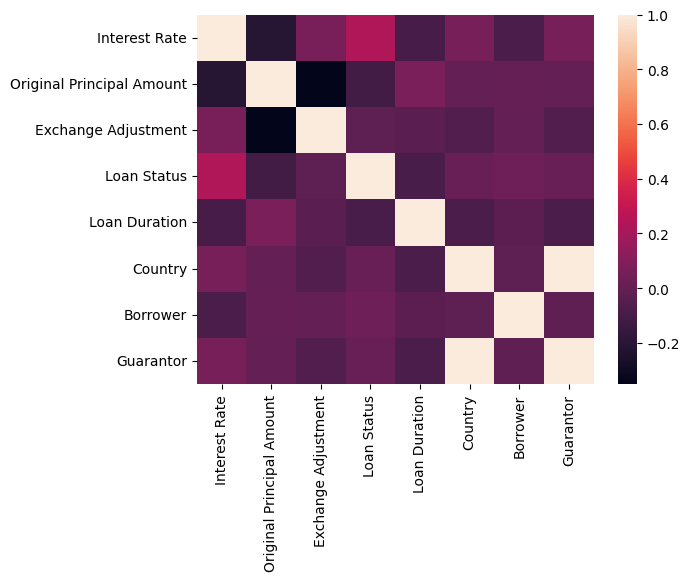

In [11]:
# covariance
c = Z.cov()

# Plot the covariance matrix
sns.heatmap(c)
plt.show()


In [12]:
eigenvalues, eigenvectors = np.linalg.eig(c)
print('Eigen values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)


Eigen values:
 [2.03057538e+00 8.34533273e-04 1.53263824e+00 6.13872369e-01
 7.21272276e-01 1.13987188e+00 1.03589521e+00 9.25040107e-01]
Eigen values Shape: (8,)
Eigen Vector Shape: (8, 8)


Sort các PC để tính ở dưới khả năng giải thích bộ dữ liệu gốc

In [13]:
# Index the eigenvalues in descending order 
idx = eigenvalues.argsort()[::-1]

# Sort the eigenvalues in descending order 
eigenvalues = eigenvalues[idx]

# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]


In [14]:
explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
explained_var


array([0.25382192, 0.4454017 , 0.58788569, 0.71737259, 0.8330026 ,
       0.92316164, 0.99989568, 1.        ])

Ta có thể xem xét sử dụng 6 PC vì giải thích trên được 90% dữ liệu

# Huấn luyện mô hình và dự đoán kết quả

Tách tập train và test (ở đây sẽ dự đoán năm 2024 nên tách từ 2020 đến 2023 là train)

In [15]:
covid_df['End of Period'] = pd.to_datetime(covid_df['End of Period'])

In [16]:
X_train = covid_df[covid_df['End of Period'].dt.year <= 2023 ][['Interest Rate', 'Original Principal Amount', 'Exchange Adjustment', 'Loan Status', 'Loan Duration', 'Country', 'Borrower', 'Guarantor']]
y_train = covid_df[covid_df['End of Period'].dt.year <= 2023]['Loans Held']
X_test = covid_df[covid_df['End of Period'].dt.year >= 2024][['Interest Rate', 'Original Principal Amount', 'Exchange Adjustment', 'Loan Status', 'Loan Duration', 'Country', 'Borrower', 'Guarantor']]
y_test = covid_df[covid_df['End of Period'].dt.year >= 2024]['Loans Held']

In [17]:
models = {
    "Gradient Boosting": GradientBoostingRegressor(),
    "Linear Regression": LinearRegression(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Elastic Net": ElasticNet(),
}

In [18]:
results = []

for model_name, model in models.items():
    # Start time measurement
    start_time = time.time()

    # Train the model
    model.fit(X_train, y_train)

    # End time measurement
    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Save results
    results.append({
        'Model': model_name, 
        'MSE': mse,
        'R^2 Score': r2,
        'MAE': mae,
        'MAPE': mape,
        'Time run': training_time
    })

# Create DataFrame from results
results_df = pd.DataFrame(results)

In [19]:
results_df

,Model,MSE,R^2 Score,MAE,MAPE,Time run
0,Gradient Boosting,8.971775e+14,0.959751,1.354278e+07,1.782039e+22,27.985183
1,Linear Regression,7.904379e+15,0.645398,4.715230e+07,1.024685e+23,0.053373
2,K-Nearest Neighbors,4.342709e+14,0.980518,4.813573e+06,6.048760e+20,0.729535
3,Elastic Net,7.947352e+15,0.643470,4.678871e+07,1.031619e+23,5.793867


Áp dụng có PCA (sẽ làm sau)

In [100]:
X = df[['Interest Rate', 'Original Principal Amount', 'Exchange Adjustment', 'Loan Status', 'Loan Duration', 'Country', 'Borrower', 'Guarantor', 'Loans Held']]
date_column = df['End of Period']

In [101]:
enc_X = OrdinalEncoder()
X[['Interest Rate', 'Original Principal Amount', 'Exchange Adjustment', 'Loan Status', 'Loan Duration', 'Country', 'Borrower', 'Guarantor']] = \
    enc_X.fit_transform(X[['Interest Rate', 'Original Principal Amount', 'Exchange Adjustment', 'Loan Status', 'Loan Duration', 'Country', 'Borrower', 'Guarantor']])

C:\Users\phat0\AppData\Local\Temp\ipykernel_19624\4010694517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Interest Rate', 'Original Principal Amount', 'Exchange Adjustment', 'Loan Status', 'Loan Duration', 'Country', 'Borrower', 'Guarantor']] = \


In [102]:
X = pd.concat([X, date_column], axis=1)
X.dropna(inplace=True)
X.reset_index(inplace=True)

In [103]:
date_column_X = X['End of Period']
y_2020 = X[['Loans Held', 'End of Period']]
X = X.drop(columns='Loans Held')

In [104]:
pca = PCA(n_components = 6)
X_pca = pca.fit_transform(X.drop(columns='End of Period'))
X_transformed = pd.DataFrame(X_pca)
X_final = pd.concat([X_transformed, date_column_X], axis=1)
X_final['End of Period'] = pd.to_datetime(X_final['End of Period'])

Tách làm 3 tập train để xem có sự ảnh hưởng:
- Tập train từ đầu năm 2020: thời điểm Covid bắt đầu bùng phát
- Tập train từ đầu năm 2022: thời điểm đa số các quốc gia đã bỏ cách ly xã hội Covid cũng cùng năm ngày 24/2 Nga nổ súng bắt đầu cuộc chiến tranh với Ukraine

Do 3 thời điểm trên là nền kinh tế có sự chuyển biến khá tốt nên nhóm nghĩ là sẽ có ảnh hưởng đến các hợp đồng cho vay

In [113]:
X_train_2020 = X_final[X_final['End of Period'].dt.year <= 2023 ].drop(columns='End of Period')
year_filter = (X_final['End of Period'].dt.year >= 2022) & (X_final['End of Period'].dt.year <= 2023)
X_train_2022 = X_final[year_filter].drop(columns='End of Period')
X_test_pca = X_final[X_final['End of Period'].dt.year >= 2024].drop(columns='End of Period')
y_2020['End of Period'] = pd.to_datetime(y_2020['End of Period'])
y_train_2020 = y_2020[y_2020['End of Period'].dt.year <= 2023].drop(columns='End of Period')
y_train_2022 = y_2020[year_filter].drop(columns='End of Period')
y_test_pca = y_2020[y_2020['End of Period'].dt.year >= 2024].drop(columns='End of Period')

In [108]:
results_2020 = []

for model_name, model in models.items():
    # Start time measurement
    start_time = time.time()

    # Train the model
    model.fit(X_train_2020, y_train_2020)

    # End time measurement
    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    
    # Predict
    y_pred = model.predict(X_test_pca)
    
    # Evaluate
    mse = mean_squared_error(y_test_pca, y_pred)
    r2 = r2_score(y_test_pca, y_pred)
    mae = mean_absolute_error(y_test_pca, y_pred)
    mape = mean_absolute_percentage_error(y_test_pca, y_pred)
    
    # Save results
    results.append({
        'Model': model_name, 
        'MSE': mse,
        'R^2 Score': r2,
        'MAE': mae,
        'MAPE': mape,
        'Time run': training_time
    })

# Create DataFrame from results
results2020_df = pd.DataFrame(results_2020)

In [117]:
results2020_df

""


In [114]:
results_2022 = []

for model_name, model in models.items():
    # Start time measurement
    start_time = time.time()

    # Train the model
    model.fit(X_train_2022, y_train_2022)

    # End time measurement
    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    
    # Predict
    y_pred = model.predict(X_test_pca)
    
    # Evaluate
    mse = mean_squared_error(y_test_pca, y_pred)
    r2 = r2_score(y_test_pca, y_pred)
    mae = mean_absolute_error(y_test_pca, y_pred)
    mape = mean_absolute_percentage_error(y_test_pca, y_pred)
    
    # Save results
    results.append({
        'Model': model_name, 
        'MSE': mse,
        'R^2 Score': r2,
        'MAE': mae,
        'MAPE': mape,
        'Time run': training_time
    })

# Create DataFrame from results
results2022_df = pd.DataFrame(results_2022)

In [116]:
results2022_df

""
